<a href="https://colab.research.google.com/github/aziz122596/Gentex/blob/main/%D1%80%D0%B0%D0%BA_%D1%8F%D0%B8%D1%87%D0%BD%D0%B8%D0%BA%D0%BE%D0%B2_24_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas scikit-learn scipy matplotlib seaborn openpyxl

In [ ]:
# **Импорт библиотек**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Импорт модулей sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer  # Импортиуем KNNImputer для импутации
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve)

In [ ]:
def load_data():
    file_path = '/content/merged_datasets.xlsx'  # Укажите путь к вашему файлу
    df_healthy = pd.read_excel(file_path, sheet_name='health')
    df_disease = pd.read_excel(file_path, sheet_name='disease')
    df_annotation = pd.read_excel(file_path, sheet_name='аннотация колонок')
    return df_healthy, df_disease, df_annotation


In [ ]:
# **2. Предобработка данных**
def preprocess_data(df_healthy, df_disease):
    # Добавляем информацию о состоянии здоровья
    df_healthy['Condition'] = 'Healthy'
    df_disease['Condition'] = 'Disease'

    # Объединяем данные
    df_combined = pd.concat([df_healthy, df_disease], ignore_index=True)

    return df_combined


In [ ]:
# **3. Добавление меток к белкам**
def label_proteins(df_combined):
    # Список белков с известными метками (больные)
    diseased_proteins = ['P01019', 'P01024', 'P02647', 'P02787']

    # Добавляем метки: 1 - больной, -1 - неразмеченный
    df_combined['Label'] = np.where(df_combined['Accession'].isin(diseased_proteins), 1, -1)

    return df_combined

In [ ]:
# **4. Подготовка данных для модели**
def prepare_data(df_combined):
    # Убираем ненужные столбцы
    data = df_combined.drop(columns=['Accession', 'Condition', 'Label'])

    # Транспонируем данные, чтобы строки соответствовали белкам
    data = data.set_index(df_combined['Accession'])
    data = data.T
    data.reset_index(drop=True, inplace=True)

    # Получаем метки
    labels = df_combined[['Accession', 'Label']].drop_duplicates().set_index('Accession')
    y = labels.loc[data.columns]['Label'].values

    # Преобразуем данные в нужный формат
    X = data.values.T  # Теперь строки - это белки

    return X, y, data.columns

In [ ]:
# **5. Импутация пропущенных значений**
def impute_missing_values(X):
    imputer = KNNImputer(n_neighbors=5)
    X_imputed = imputer.fit_transform(X)
    return X_imputed

In [ ]:
# **6. Полуобученное обучение**
def semi_supervised_learning(X_imputed, y):
    # Масштабируем данные
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Обучаем модель Label Spreading
    label_spread = LabelSpreading(kernel='knn', n_neighbors=5, alpha=0.2)
    label_spread.fit(X_scaled, y)

    # Получаем предсказанные метки
    y_transduced = label_spread.transduction_

    return X_scaled, y_transduced

In [ ]:
# **7. Обучение и оценка модели**
def train_and_evaluate(X_scaled, y_transduced):
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_transduced, test_size=0.2, random_state=42, stratify=y_transduced)

    # Обучаем модель
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Оценка модели
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f'\nТочность на тестовом наборе: {accuracy:.4f}')
    print(f'ROC-AUC на тестовом наборе: {roc_auc:.4f}')
    print('\nОтчет о классификации:')
    print(classification_report(y_test, y_pred))

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.show()

    # Кривая ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    plt.show()

    # Кривая Precision-Recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Кривая Precision-Recall')
    plt.legend()
    plt.show()

In [ ]:
# **8. Запуск всего процесса**
def main():
    df_healthy, df_disease, df_annotation = load_data()
    df_combined = preprocess_data(df_healthy, df_disease)
    df_combined = label_proteins(df_combined)
    X, y, protein_names = prepare_data(df_combined)
    X_imputed = impute_missing_values(X)
    X_scaled, y_transduced = semi_supervised_learning(X_imputed, y)
    train_and_evaluate(X_scaled, y_transduced)

if __name__ == "__main__":
    main()

NameError: name 'LabelSpreading' is not defined

In [ ]:
# # **2. Предобработка данных**
# def preprocess_data(df_healthy, df_disease):
#     # Фильтрация доступных белков
#     available_proteins = df_disease['Accession'].dropna().unique()

#     # Фильтрация и транспонирование данных больных пациентов
#     df_disease_filtered = df_disease[df_disease['Accession'].isin(available_proteins)]
#     df_disease_filtered = df_disease_filtered.set_index('Accession').T
#     df_disease_filtered.columns.name = None
#     df_disease_filtered.reset_index(drop=True, inplace=True)

#     # Фильтрация и транспонирование данных здоровых пациентов
#     df_healthy_filtered = df_healthy[df_healthy['Accession'].isin(available_proteins)]
#     df_healthy_filtered = df_healthy_filtered.set_index('Accession').T
#     df_healthy_filtered.columns.name = None
#     df_healthy_filtered.reset_index(drop=True, inplace=True)

#     # Добавление меток
#     df_disease_filtered['Health_Status'] = 1  # Больные
#     df_healthy_filtered['Health_Status'] = 0  # Здоровые

#     # Объединение данных
#     df_combined = pd.concat([df_disease_filtered, df_healthy_filtered], ignore_index=True)
#     return df_combined

In [ ]:
# def impute_missing_values(df_combined):
#     data_to_impute = df_combined.drop(columns=['Health_Status']).copy()

#     # Идентифицируем столбцы с полными NaN
#     cols_with_all_nan = data_to_impute.columns[data_to_impute.isna().all()]
#     print(f"Найдено {len(cols_with_all_nan)} столбцов, содержащих только NaN. Они будут удалены перед импутацией.")

#     # Удаляем эти столбцы
#     data_to_impute = data_to_impute.drop(columns=cols_with_all_nan)

#     imputer = KNNImputer(n_neighbors=5)
#     X_imputed = imputer.fit_transform(data_to_impute)

#     # Создаем DataFrame с импутированными данными
#     df_imputed = pd.DataFrame(X_imputed, columns=data_to_impute.columns)

#     # Добавляем метку состояния здоровья обратно в DataFrame
#     df_imputed['Health_Status'] = df_combined['Health_Status'].values

#     # Проверка на наличие оставшихся пропущенных значений
#     remaining_nans = df_imputed.isna().sum().sum()
#     print(f"Количество оставшихся пропущенных значений после импутации: {remaining_nans}")

#     return df_imputed


In [ ]:
# # **4. Анализ данных**
# def exploratory_data_analysis(df_imputed):
#     # Проверка баланса классов
#     sns.countplot(x='Health_Status', data=df_imputed)
#     plt.title('Распределение классов')
#     plt.xticks([0, 1], ['Здоровые', 'Больные'])
#     plt.show()

#     # Корреляция признаков с меткой класса
#     correlation = df_imputed.corr()['Health_Status'].sort_values(ascending=False)
#     print("Топ 10 признаков, коррелирующих с классом:")
#     print(correlation.head(11))  # включая 'Health_Status'
#     print("\n")

In [ ]:
# **5. Выбор признаков**
# def feature_selection(df_imputed):
#     Выбор топ-20 признаков на основе корреляции
#     top_features = df_imputed.corr()['Health_Status'].abs().sort_values(ascending=False).head(21).index
#     selected_features = [feat for feat in top_features if feat != 'Health_Status']
#     return selected_features

# **6. Разделение данных**
# def split_data(df_imputed, selected_features):
#     X = df_imputed[selected_features]
#     y = df_imputed['Health_Status']

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#     return X_train, X_test, y_train, y_test

# **7. Масштабирование данных**
# def scale_data(X_train, X_test):
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
#     return X_train_scaled, X_test_scaled

In [ ]:
# # **6. Полуобученное обучение с использованием Label Spreading**
# def semi_supervised_learning(df_imputed, selected_features):
#     from sklearn.semi_supervised import LabelSpreading
#     from sklearn.preprocessing import StandardScaler

#     # Предположим, что только часть данных размечена (например, 5% данных)
#     labeled_fraction = 0.05
#     df_imputed = df_imputed.sample(frac=1, random_state=42).reset_index(drop=True)  # Перемешиваем данные

#     num_labeled = int(len(df_imputed) * labeled_fraction)
#     df_labeled = df_imputed.iloc[:num_labeled]
#     df_unlabeled = df_imputed.iloc[num_labeled:]

#     X_labeled = df_labeled[selected_features].values
#     y_labeled = df_labeled['Health_Status'].values.astype(int)

#     X_unlabeled = df_unlabeled[selected_features].values

#     # Объединяем данные
#     X_total = np.vstack((X_labeled, X_unlabeled))
#     y_unlabeled = -1 * np.ones(len(X_unlabeled), dtype=int)
#     y_total = np.concatenate((y_labeled, y_unlabeled))

#     # Масштабируем данные
#     scaler = StandardScaler()
#     X_total_scaled = scaler.fit_transform(X_total)

#     # Обучаем модель Label Spreading
#     label_spread = LabelSpreading(kernel='knn', n_neighbors=5)
#     label_spread.fit(X_total_scaled, y_total)

#     # Предсказываем метки для неразмеченных данных
#     transduced_labels = label_spread.transduction_

#     # Обновляем DataFrame с предсказанными метками
#     df_unlabeled['Health_Status'] = transduced_labels[num_labeled:]
#     df_combined = pd.concat([df_labeled, df_unlabeled], ignore_index=True)

#     return df_combined, scaler

In [ ]:
# # **7. Разделение данных**
# def split_data(df_combined, selected_features):
#     X = df_combined[selected_features]
#     y = df_combined['Health_Status']

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#     return X_train, X_test, y_train, y_test

In [ ]:
# # **8. Масштабирование данных**
# def scale_data(X_train, X_test, scaler=None):
#     if scaler is None:
#         scaler = StandardScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#     else:
#         X_train_scaled = scaler.transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
#     return X_train_scaled, X_test_scaled, scaler

In [ ]:
# # **9. Настройка гиперпараметров и обучение модели**
# def train_model(X_train_scaled, y_train):
#     # Параметры для поиска
#     param_grid = {
#         'n_estimators': [100, 200, 500],
#         'max_depth': [None, 5, 10, 20],
#         'min_samples_split': [2, 5, 10]
#     }
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, n_jobs=-1, scoring='roc_auc')
#     grid_search.fit(X_train_scaled, y_train)
#     print(f"Лучшие параметры: {grid_search.best_params_}")
#     return grid_search.best_estimator_

In [ ]:
# # **10. Оценка модели**
# def evaluate_model(model, X_test_scaled, y_test):
#     y_pred = model.predict(X_test_scaled)
#     y_proba = model.predict_proba(X_test_scaled)[:, 1]

#     accuracy = accuracy_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_proba)

#     print(f'\nТочность на тестовом наборе: {accuracy:.4f}')
#     print(f'ROC-AUC на тестовом наборе: {roc_auc:.4f}')
#     print('\nОтчет о классификации:')
#     print(classification_report(y_test, y_pred, target_names=['Здоров', 'Болен']))

#     # Матрица ошибок
#     cm = confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Здоров', 'Болен'], yticklabels=['Здоров', 'Болен'])
#     plt.xlabel('Предсказанный класс')
#     plt.ylabel('Истинный класс')
#     plt.title('Матрица ошибок')
#     plt.show()

#     # Кривая ROC
#     fpr, tpr, thresholds = roc_curve(y_test, y_proba)
#     plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC-кривая')
#     plt.legend()
#     plt.show()

#     # Кривая Precision-Recall
#     precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
#     plt.plot(recall, precision, label='Precision-Recall curve')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Кривая Precision-Recall')
#     plt.legend()
#     plt.show()

Найдено 129 столбцов, содержащих только NaN. Они будут удалены перед импутацией.
Количество оставшихся пропущенных значений после импутации: 0


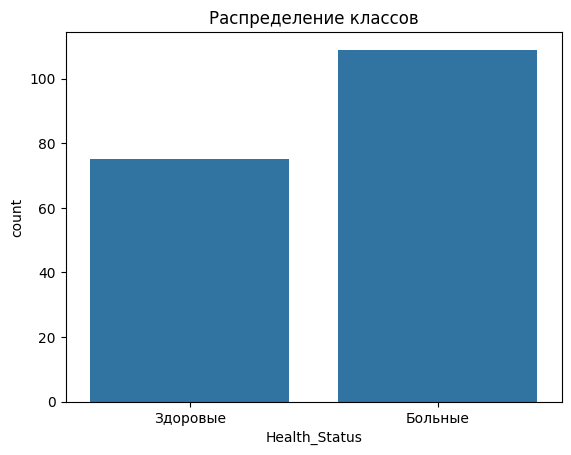

Топ 10 признаков, коррелирующих с классом:
Health_Status    1.000000
Q8IV63           0.527344
O60522           0.441463
Q12906-7         0.409319
P07948           0.407988
Q6P4E1-4         0.405451
P10451-5         0.390696
P01624           0.389550
P08581-2         0.387681
Q8WVM8           0.381120
Q8IZ81           0.352845
Name: Health_Status, dtype: float64


Лучшие параметры: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Точность на тестовом наборе: 0.9459
ROC-AUC на тестовом наборе: 0.9620

Отчет о классификации:
              precision    recall  f1-score   support

      Здоров       1.00      0.89      0.94        19
       Болен       0.90      1.00      0.95        18

    accuracy                           0.95        37
   macro avg       0.95      0.95      0.95        37
weighted avg       0.95      0.95      0.95        37



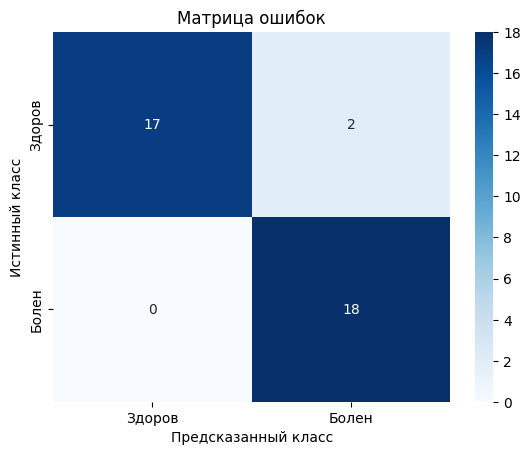

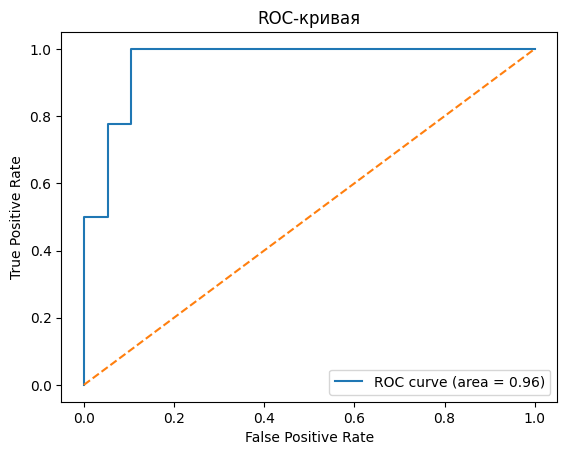

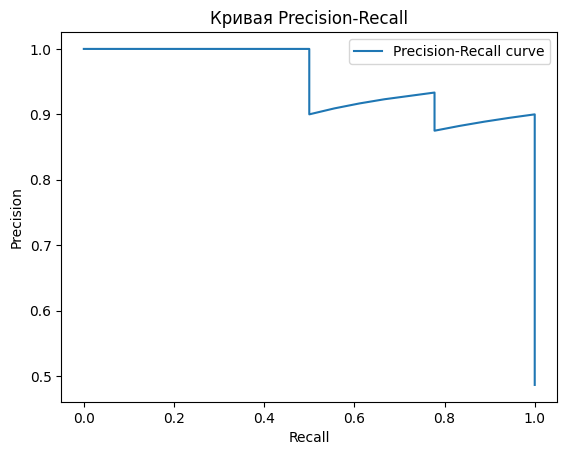

In [ ]:
# # **11. Запуск всего процесса**
# def main():
#     df_healthy, df_disease, df_annotation = load_data()
#     df_combined = preprocess_data(df_healthy, df_disease)
#     df_imputed = impute_missing_values(df_combined)
#     exploratory_data_analysis(df_imputed)
#     selected_features = feature_selection(df_imputed)
#     df_semi_supervised, scaler = semi_supervised_learning(df_imputed, selected_features)
#     X_train, X_test, y_train, y_test = split_data(df_semi_supervised, selected_features)
#     X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test, scaler)
#     model = train_model(X_train_scaled, y_train)
#     evaluate_model(model, X_test_scaled, y_test)

# if __name__ == "__main__":
#     main()

In [ ]:
# 8. Настройка гиперпараметров и обучение модели**
# def train_model(X_train_scaled, y_train):
#     # Параметры для поиска
#     param_grid = {
#         'n_estimators': [100, 200, 500],
#         'max_depth': [None, 5, 10, 20],
#         'min_samples_split': [2, 5, 10]
#     }
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, n_jobs=-1, scoring='roc_auc')
#     grid_search.fit(X_train_scaled, y_train)
#     print(f"Лучшие параметры: {grid_search.best_params_}")
#     return grid_search.best_estimator_

In [ ]:
# **9. Оценка модели**
# def evaluate_model(model, X_test_scaled, y_test):
#     y_pred = model.predict(X_test_scaled)
#     y_proba = model.predict_proba(X_test_scaled)[:, 1]

#     accuracy = accuracy_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_proba)

#     print(f'\nТочность на тестовом наборе: {accuracy:.4f}')
#     print(f'ROC-AUC на тестовом наборе: {roc_auc:.4f}')
#     print('\nОтчет о классификации:')
#     print(classification_report(y_test, y_pred, target_names=['Здоров', 'Болен']))

#     # Матрица ошибок
#     cm = confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Здоров', 'Болен'], yticklabels=['Здоров', 'Болен'])
#     plt.xlabel('Предсказанный класс')
#     plt.ylabel('Истинный класс')
#     plt.title('Матрица ошибок')
#     plt.show()

#     # Кривая ROC
#     fpr, tpr, thresholds = roc_curve(y_test, y_proba)
#     plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC-кривая')
#     plt.legend()
#     plt.show()

#     # Кривая Precision-Recall
#     precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
#     plt.plot(recall, precision, label='Precision-Recall curve')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Кривая Precision-Recall')
#     plt.legend()
#     plt.show()

Найдено 129 столбцов, содержащих только NaN. Они будут удалены перед импутацией.
Количество оставшихся пропущенных значений после импутации: 0


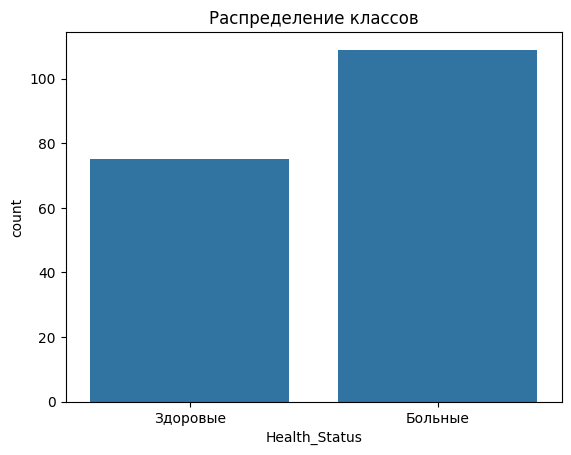

Топ 10 признаков, коррелирующих с классом:
Health_Status    1.000000
Q8IV63           0.527344
O60522           0.441463
Q12906-7         0.409319
P07948           0.407988
Q6P4E1-4         0.405451
P10451-5         0.390696
P01624           0.389550
P08581-2         0.387681
Q8WVM8           0.381120
Q8IZ81           0.352845
Name: Health_Status, dtype: float64


Лучшие параметры: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Точность на тестовом наборе: 0.9189
ROC-AUC на тестовом наборе: 0.9818

Отчет о классификации:
              precision    recall  f1-score   support

      Здоров       1.00      0.80      0.89        15
       Болен       0.88      1.00      0.94        22

    accuracy                           0.92        37
   macro avg       0.94      0.90      0.91        37
weighted avg       0.93      0.92      0.92        37



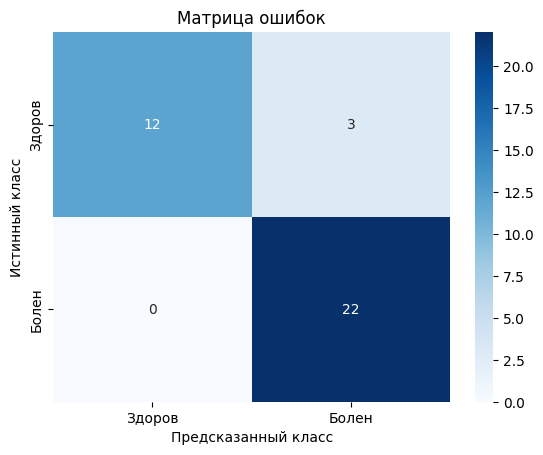

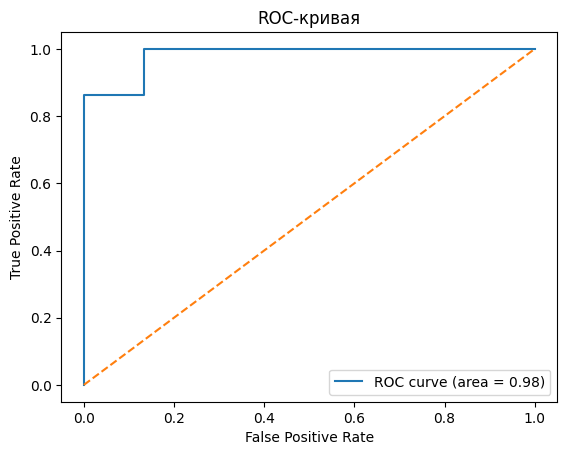

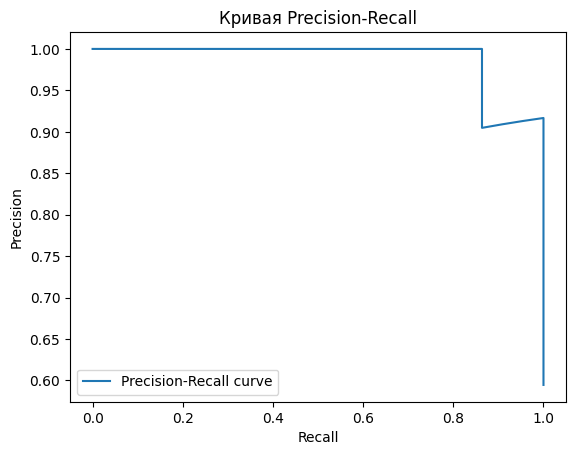

In [ ]:
# # **10. Запуск всего процесса**
# def main():
#     df_healthy, df_disease, df_annotation = load_data()
#     df_combined = preprocess_data(df_healthy, df_disease)
#     df_imputed = impute_missing_values(df_combined)
#     exploratory_data_analysis(df_imputed)
#     selected_features = feature_selection(df_imputed)
#     X_train, X_test, y_train, y_test = split_data(df_imputed, selected_features)
#     X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
#     model = train_model(X_train_scaled, y_train)
#     evaluate_model(model, X_test_scaled, y_test)

# if __name__ == "__main__":
#     main()

In [ ]:
def semi_supervised_learning(df_imputed, selected_features):
    from sklearn.semi_supervised import LabelSpreading
    from sklearn.preprocessing import StandardScaler

    # Разделяем данные на размеченные и неразмеченные
    df_labeled = df_imputed[df_imputed['Health_Status'].notna()]
    df_unlabeled = df_imputed[df_imputed['Health_Status'].isna()]

    X_labeled = df_labeled[selected_features].values
    y_labeled = df_labeled['Health_Status'].values.astype(int)

    X_unlabeled = df_unlabeled[selected_features].values

    # Объединяем данные
    X_total = np.vstack((X_labeled, X_unlabeled))
    y_unlabeled = -1 * np.ones(len(X_unlabeled), dtype=int)
    y_total = np.concatenate((y_labeled, y_unlabeled))

    # Масштабируем данные
    scaler = StandardScaler()
    X_total_scaled = scaler.fit_transform(X_total)

    # Обучаем модель Label Spreading
    label_spread = LabelSpreading(kernel='knn', n_neighbors=5)
    label_spread.fit(X_total_scaled, y_total)

    # Предсказываем метки для неразмеченных данных
    predicted_labels = label_spread.transduction_[-len(X_unlabeled):]

    # Добавляем предсказанные метки в исходный DataFrame
    df_unlabeled['Health_Status'] = predicted_labels
    df_combined = pd.concat([df_labeled, df_unlabeled], ignore_index=True)

    return df_combined


Найдено 129 столбцов, содержащих только NaN. Они будут удалены перед импутацией.
Количество оставшихся пропущенных значений после импутации: 0


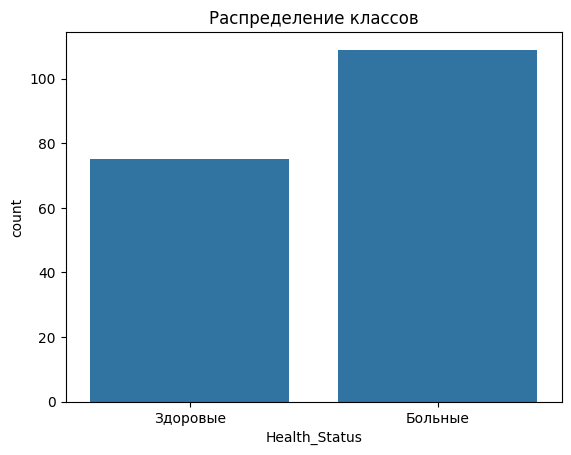

Топ 10 признаков, коррелирующих с классом:
Health_Status    1.000000
Q8IV63           0.527344
O60522           0.441463
Q12906-7         0.409319
P07948           0.407988
Q6P4E1-4         0.405451
P10451-5         0.390696
P01624           0.389550
P08581-2         0.387681
Q8WVM8           0.381120
Q8IZ81           0.352845
Name: Health_Status, dtype: float64


Лучшие параметры: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Точность на тестовом наборе: 0.9189
ROC-AUC на тестовом наборе: 0.9818

Отчет о классификации:
              precision    recall  f1-score   support

      Здоров       1.00      0.80      0.89        15
       Болен       0.88      1.00      0.94        22

    accuracy                           0.92        37
   macro avg       0.94      0.90      0.91        37
weighted avg       0.93      0.92      0.92        37



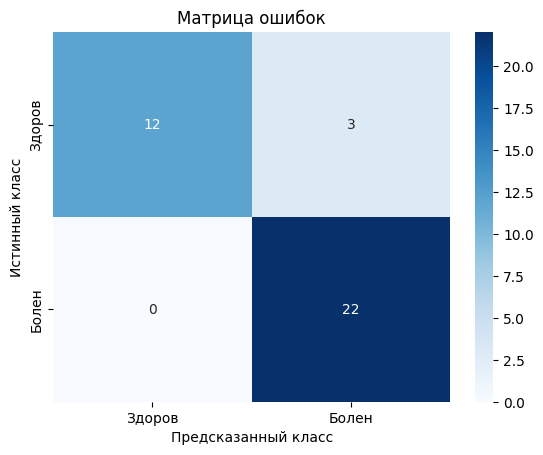

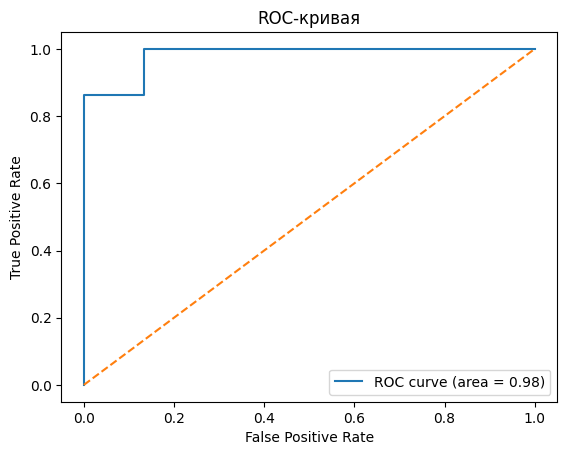

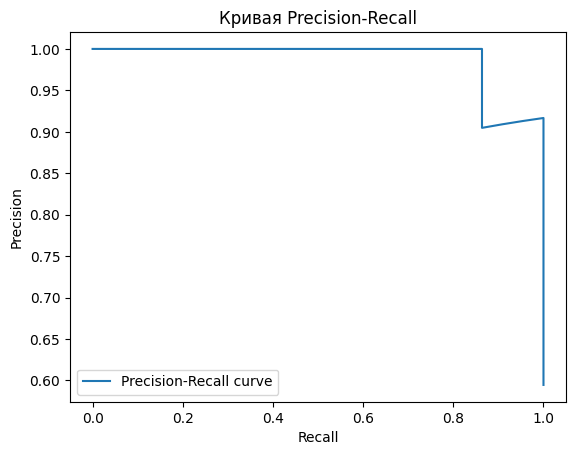

In [ ]:
if __name__ == "__main__":
    main()
